In [ ]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
import datetime

from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import RFECV, SelectFromModel

In [ ]:
# データの読み込み
train = pd.read_csv("MUFG_train.csv")
test = pd.read_csv("MUFG_test.csv")
sample = pd.read_csv("MUFG_submit_sample.csv",header=None)

print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Train: (337, 12) Test: (144, 11) Sample: (144, 2)


In [ ]:
train.head()

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0,Tue,1,メンチカツ,377.0,NaN,NaN,NaN,晴時々薄曇,0.0,13.9
1,2014-04-02,99.0,Wed,0,肉じゃが,380.0,NaN,NaN,NaN,薄曇一時晴,0.0,15.2
2,2014-04-03,100.0,Thu,1,酢豚,390.0,NaN,NaN,NaN,大雨,65.0,13.8
3,2014-04-04,90.0,Fri,1,和風ソースハンバーグ,350.0,NaN,NaN,NaN,晴時々曇一時雨、雷を伴う,40.0,15.3
4,2014-04-07,107.0,Mon,0,青梗菜牛肉炒め,387.0,NaN,NaN,NaN,晴後一時薄曇,0.0,11.4


In [ ]:
train.isnull().sum()

dateid             0
y                  0
week               0
soldout            0
name               0
kcal              33
remarks          288
event            309
payday           320
weather            0
precipitation      0
temperature        0
dtype: int64

In [ ]:
print(train['remarks'].unique())
print(train['event'].unique())
print(train['payday'].unique())

[nan 'お楽しみメニュー' '料理長のこだわりメニュー' 'スペシャルメニュー' '近隣に飲食店複合ビルオープン' '料理長イチオシ！'
 '料理長イチオシ!' '今月のイチオシ!' '今月のこだわりメニュー' 'コンビニ改装' '弁当種類増↓']
[nan 'ママの会' 'キャリアアップ支援セミナー']
[nan  1.]


In [ ]:
# 欠損値補完
train['kcal'] = train['kcal'].fillna(419)
train['remarks'] = train['remarks'].fillna('なし')
train['event'] = train['event'].fillna('なし')
train['payday'] = train['payday'].fillna(0)

In [ ]:
train['y'].describe()

count    337.000000
mean      65.192878
std       20.645712
min       25.000000
25%       53.000000
50%       62.000000
75%       72.000000
max      137.000000
Name: y, dtype: float64

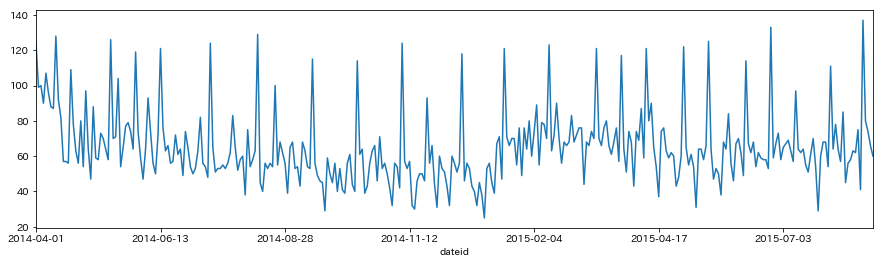

In [ ]:
# 図で確認
train.index = train['dateid']
train['y'].plot(figsize=(15,4))

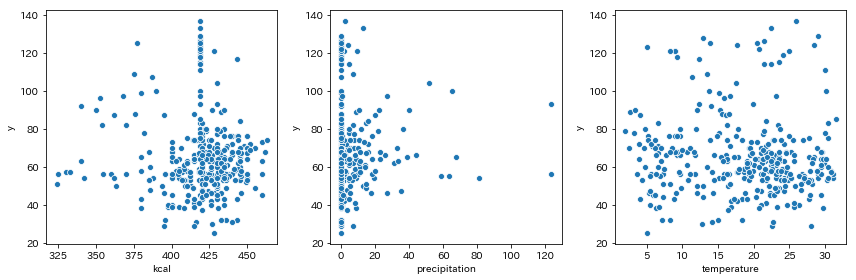

In [ ]:
# 図で確認
fig, ax = plt.subplots(1,3,figsize=(12,4))
sns.scatterplot(x="kcal",y="y",data=train,ax=ax[0])
sns.scatterplot(x="precipitation",y="y",data=train,ax=ax[1])
sns.scatterplot(x="temperature",y="y",data=train,ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
train[['y','kcal','precipitation','temperature']].corr()

,y,kcal,precipitation,temperature
y,1.000000,-0.042231,0.079831,-0.063523
kcal,-0.042231,1.000000,0.014013,-0.197729
precipitation,0.079831,0.014013,1.000000,-0.018038
temperature,-0.063523,-0.197729,-0.018038,1.000000


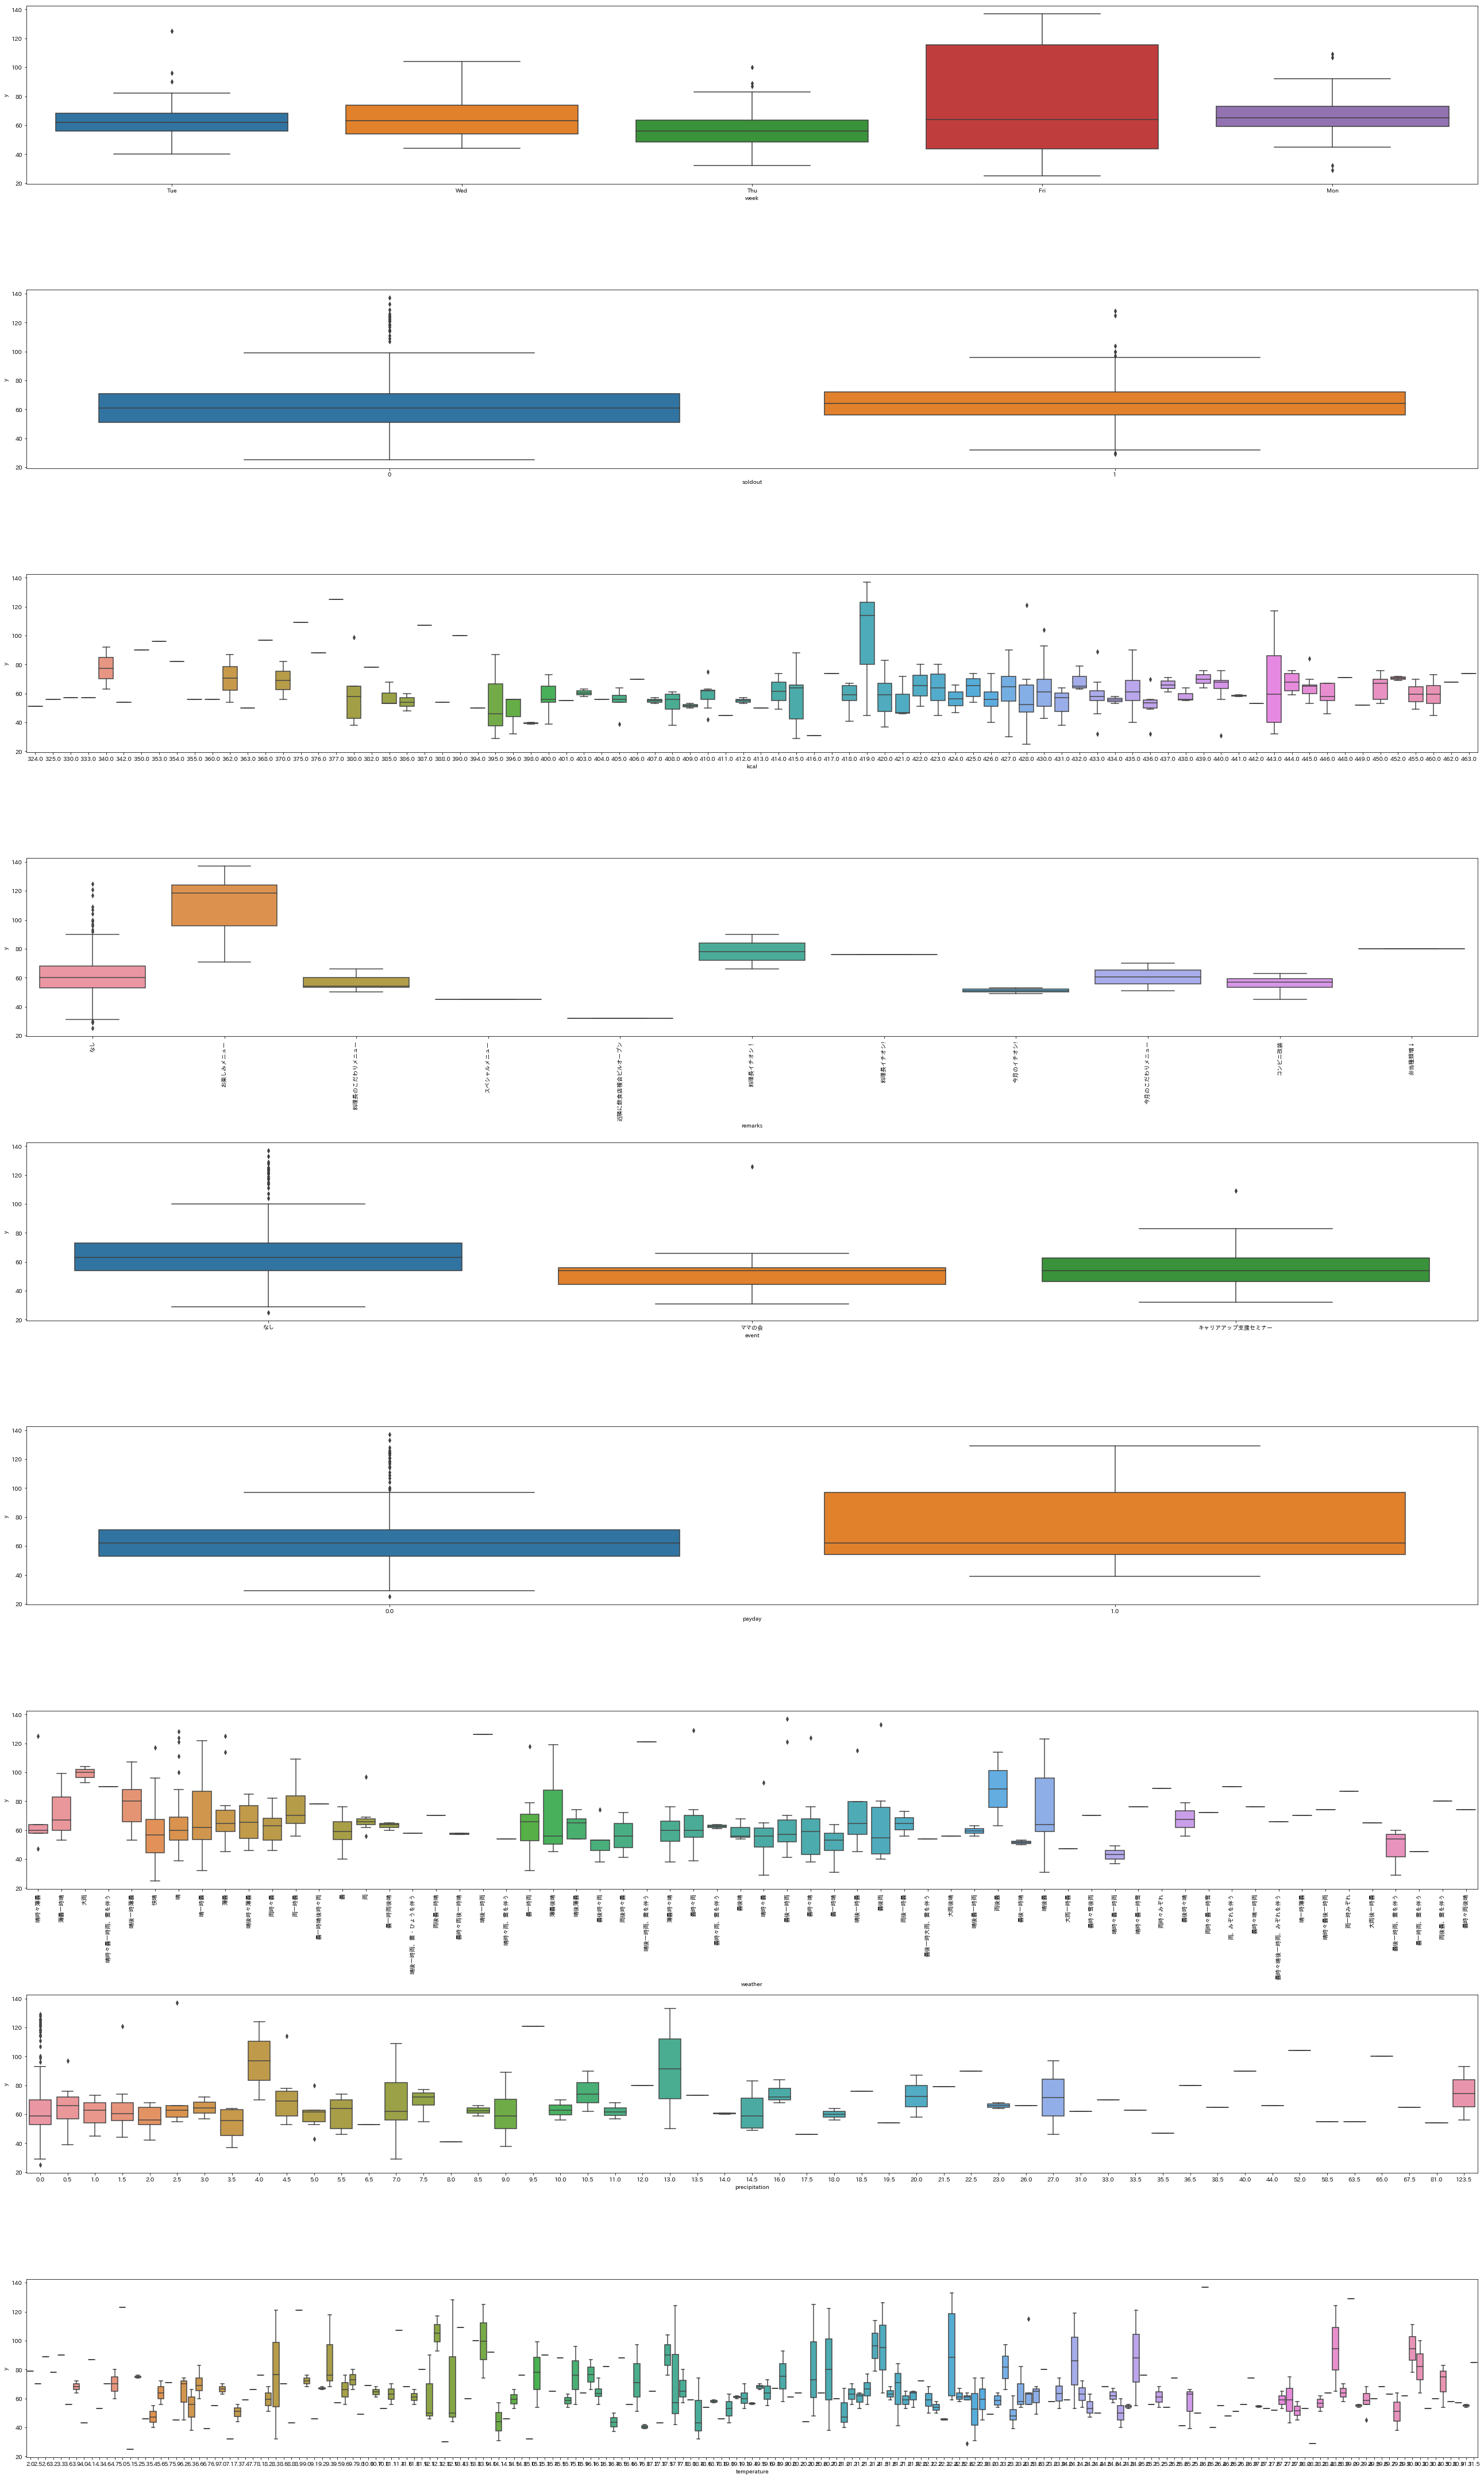

In [ ]:
# 図で確認
fig, ax = plt.subplots(9,1,figsize=(36,60))
sns.boxplot(x="week",y="y",data=train,ax=ax[0])
sns.boxplot(x="soldout",y="y",data=train,ax=ax[1])
sns.boxplot(x="kcal",y="y",data=train,ax=ax[2])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[3])
ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation=90)
sns.boxplot(x="event",y="y",data=train,ax=ax[4])
sns.boxplot(x="payday",y="y",data=train,ax=ax[5])
sns.boxplot(x="weather",y="y",data=train,ax=ax[6])
ax[6].set_xticklabels(ax[6].get_xticklabels(),rotation=90)
sns.boxplot(x="precipitation",y="y",data=train,ax=ax[7])
sns.boxplot(x="temperature",y="y",data=train,ax=ax[8])

plt.tight_layout()
plt.show()

In [ ]:
# メニューのジャンル毎にグループ化
train['name'].value_counts()

メンチカツ             9
タンドリーチキン          7
豚キムチ炒め            6
カレーライス            6
ポークカレー            6
親子煮               6
豚肉のマスタード焼き        5
ポーク生姜焼き           5
麻婆豆腐              5
チンジャオロース          4
チキンカレー            4
豚柳川               4
エビフライ             4
手作りチキンカツ          4
鶏肉の唐揚げ            4
酢豚                4
チーズメンチカツ          4
白身魚ムニエル           3
自家製手作りトンカツ        3
鶏の味噌漬け焼き          3
バーベキューチキン         3
手作りロースカツ          3
塩唐揚げ              3
白身魚カレームニエル        3
牛丼風煮              3
肉じゃが              3
キーマカレー            3
ビーフストロガノフ         3
チキンの辛味噌焼き         2
牛肉コロッケ            2
                 ..
厚切ハムカツ            1
牛すき焼き風            1
ゴーヤチャンプルー         1
白身魚フライ            1
マーボー豆腐            1
ハムカツ              1
ビーフトマト煮           1
ハンバーグ・ミートソース      1
鶏の照り焼きマヨ          1
炊き込みご飯・コロッケ       1
牛カルビ焼き肉           1
エビフライ・エビカツ        1
豚肉の味噌焼き           1
唐揚げ丼              1
スキヤキ煮込み           1
白身魚の南部焼き          1
マス塩焼き             1
ぶりレモンペッパー焼き       1
ポークソテー・オニオンソース    1


In [ ]:
train = pd.read_csv("MUFG_train.csv")
test = pd.read_csv("MUFG_test.csv")

# データの前処理
train['train'] = 1
test['train'] = 0
data = pd.concat([train,test])
data['dateid'] = pd.to_datetime(data['dateid'])
data = data.set_index('dateid')

data['event'] = data['event'].fillna('なし')
data['payday'] = data['payday'].fillna(0)

select_cols = ['week',
               'remarks',
               'event',
               'payday',
               'weather',
               "",
               'train',
               'y']

data = pd.get_dummies(data[select_cols])

train = data[data['train']==1]
test = data[data['train']==0]

train = train.drop(columns=['train'])
test = test.drop(columns=['train'])

# 学習データと評価用データに分割
tr = train[train.index < datetime.datetime(2015,4,1)]
val = train[train.index >= datetime.datetime(2015,4,1)]

tr_X = tr.drop(columns=['y'])
tr_y = tr['y']
val_X = val.drop(columns=['y'])
val_y = val['y']

# 学習&予測
model = RandomForestRegressor(random_state=42)
model.fit(tr_X, tr_y)
tr_pred = model.predict(tr_X)
val_pred = model.predict(val_X)

# RMSEの算出
print("TRAIN:",MSE(tr_y, tr_pred)**0.5, "VARIDATE",MSE(val_y, val_pred)**0.5)

y_pred = model.predict(tr_X)

mae = mean_absolute_error(tr_y, y_pred)
mse = mean_squared_error(tr_y, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

TRAIN: 10.694287652308052 VARIDATE 13.709103018167811
MAE: 7.25
MSE: 1.14e+02
RMSE: 10.7


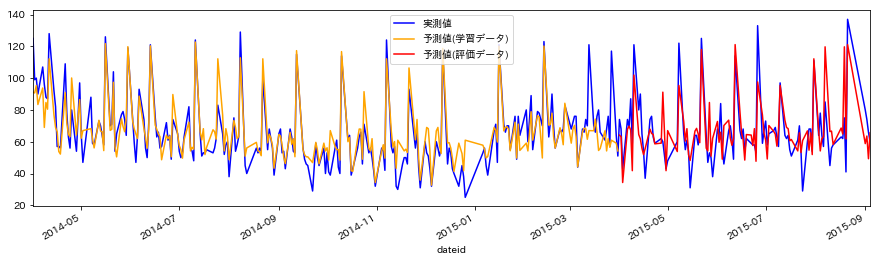

In [ ]:
tr['pred'] = tr_pred
val['pred'] = val_pred

plt.figure(figsize=(15,4))
pd.concat([tr, val])['y'].plot(color='blue', label='実測値')
tr['pred'].plot(color='orange', label='予測値(学習データ)')
val['pred'].plot(color='red', label='予測値(評価データ)')
plt.legend()

In [ ]:
sample = pd.read_csv("MUFG_submit_sample.csv",header=None)
test_X = test.drop(columns=['y'])
test_pred = model.predict(test_X)
sample[1] = test_pred
sample.to_csv('sample16.csv', header=None, index=None)